# Bitcoin Time Series Prediction with LSTM

#### Import necessary library needed for the model training

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


#### Use Quandl api to get BTC/USD data from kraken exchange

In [2]:
data = pd.read_csv("merged_data.csv")

In [3]:
data.tail()

,Unnamed: 0,stamp,price,sentiment
636,439,2017-11-09,7195.0,0.380219
637,366,2017-11-10,6704.1,0.380219
638,108,2017-11-11,6079.3,0.380219
639,586,2017-11-12,6241.0,0.380219
640,603,2017-11-13,6570.0,0.380219


In [4]:
data = data.sort_values(by='stamp')

#data['stamp'] = pd.to_datetime(data['stamp'].apply(str),format='%Y%m%d')
#data = data.sort_values(by='stamp')
#data.to_csv('data-sort.csv')
data.drop(data.columns[0],axis=1,inplace=True)
data.head()

,stamp,price,sentiment
0,2016-02-11,379.2,0.306488
1,2016-02-12,389.0,0.260142
2,2016-02-13,397.7,0.304902
3,2016-02-14,406.8,0.308635
4,2016-02-15,400.9,0.321268


#### Plot line graph base on `Weighted Price`

In [5]:
btc_trace = go.Scatter(x=data['stamp'], y=data['price'], name= 'Price')
py.iplot([btc_trace])

#### Fill value 0 data points on `Weighted Price` with NAN and then use ffill method to fill values

In [6]:
data['price'].replace(0, np.nan, inplace=True)
data['price'].fillna(method='ffill', inplace=True)

#### Plot new line graph again on `Weighted Price` with newly filled values

In [7]:
btc_trace = go.Scatter(x=data['stamp'], y=data['price'], name= 'Price')
py.iplot([btc_trace])

### Using `Weighted Price` as a feature to train the LSTM model 

#### Use MinMaxScaler to normalize `Weighted Price` to range from 0 to 1

In [8]:
from sklearn.preprocessing import MinMaxScaler
values = data['price'].values.reshape(-1,1)
sentiment = data['sentiment'].values.reshape(-1,1)
values = values.astype('float32')
sentiment = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Split 70% of data for training and 30% for testing

In [9]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
split = train_size

448 193


#### Create function for creating dataset with look back

In [36]:
def create_dataset(dataset, look_back, sentiment):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        a = np.append(a,sentiment[i])
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

#### Generate dataset for trainX, trainY, testX, testY

In [37]:
look_back = 1
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size])
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)])

447
191


In [38]:
trainX.shape

(447, 2)

#### Reshape X for model training

In [39]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Running the LSTM model with 300 epochs

In [40]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

#### Plot line graph to show amount loss according the the epoch

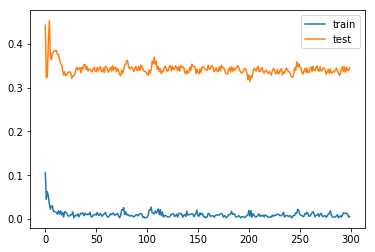

In [41]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY

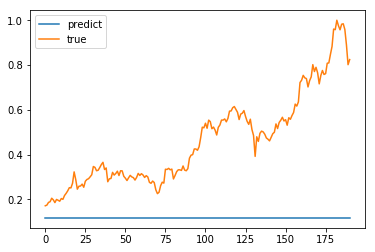

In [42]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [43]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

#### RMSE

In [44]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2856.187


#### Plot line graph with Y as USD

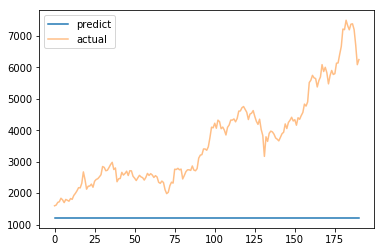

In [45]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Convert X to dates

In [46]:
predictDates = data.tail(len(testX)).stamp

#### Reshape testY and yhat for plotly

In [47]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

#### Plot predicted and actual line graph with X=dates, Y=USD

In [49]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])